### Content

This notebook shows how to carry out thematic modeling to a collection of news articles downloaded from the RBS website. The model will be rendered and a prototype of the thematic collection navigator will be created. The collection contains 1601 documents, the size of the dictionary is 1000 words. The words are lemmatized, that is, brought to their initial form, using the mystem program, the collection is saved in the UCI format. 

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

/home/aliak/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
/home/aliak/anaconda3/lib/python3.7/site-packages/scipy/linalg/__init__.py:212: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/home/aliak/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:16: DeprecationWarning: `np.typeD

In [3]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib

/home/aliak/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Reading the data**

Here an object of the artm.BatchVectorizer class is created, which will refer to the directory with data packages (batches).

The batch size for small collections is not important, you can specify any.

If you have data in UCI format
(e.g. vocab.my_collection.txt and docword.my_collection.txt files),
that were put into the same directory with your script or notebook,
you can create batches using next code:

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path='.',
                                        data_format='bow_uci',
                                        collection_name='rbc',
                                        target_folder='rbc_batches')

In [6]:
np.random.seed(1)
my_dictionary = artm.Dictionary('dict')
my_dictionary.gather(batch_vectorizer.data_path)
# my_dictionary.save(dictionary_path='rbc_batches/my_dictionary')
# my_dictionary.load(dictionary_path='rbc_batches/my_dictionary.dict')

**Initializing the model** 

An object of class artm.Model is created with 26 themes, the names of the themes given below, and unit weights of both modalities. The number of themes is not very large, so that it is more convenient to work with themes. More themes can be built on this collection, then they will be more narrowly specialized.

In [8]:
T = 26 # number of topics
topic_names=["Topic_"+(str(i)) for i in range(T-1)]+["bcg"]

model = artm.ARTM(num_topics=T, topic_names=topic_names, num_processors=2,
                  reuse_theta=True, cache_theta=True, dictionary=my_dictionary)

In [10]:
model.initialize(dictionary=my_dictionary)

In [11]:
batch_vectorizer.dictionary

artm.Dictionary(name=42c596fc-a3d6-4c3c-8385-4cc77a8740f8, num_entries=1000)

**Model building**

Here the model is built in two stages: first, the smoothing regularizer of the background theme is added and the parameters of the model are adjusted, then the thinning regularizer of subject themes is added and several more iterations are performed. So we will be able to get the most pure subject topics from background words. Smoothing and sparse regularizers are specified by the same class artm.SmoothSparsePhiRegularizer: if the tau coefficient is positive, then the regularizer will be smoothing, if negative, it will be sparse.

In [12]:
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod1', num_tokens=15))

In [13]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, class_ids='text', dictionary='dict', topic_names='bcg'))

In [14]:
model.num_document_passes = 1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=26)

In [15]:
topic_names_cleared = list(topic_names).remove('bcg')
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, class_ids='text', dictionary='dict',
                                                       topic_names=topic_names_cleared))

In [16]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

**Interpreting Topics**

Using the created scores, it's displayed tops of words and tops of headlines in topics. It is most convenient to display the top words of each topic on a new line, indicating the topic name at the beginning of the line, and similarly with the headlines.

In [18]:
tokens = model.score_tracker['top_tokens_score_mod1'].last_tokens
for topic_name in model.topic_names:
    print (topic_name + ': ')
    for word in tokens[topic_name]:    
        print(word, end = ", ")
    print("\n")

Topic_0: 
банк, счет, средство, валюта, рубль, минфин, платеж, доллар, валютный, цб, клиент, финансовый, евро, операция, денежный, 

Topic_1: 
президент, владимир, путин, украина, заявлять, военный, украинский, пресс, называть, секретарь, киев, российский, сша, действие, политик, 

Topic_2: 
рост, вырастать, цена, сравнение, приходиться, составлять, спрос, уровень, снижаться, отмечать, месяц, инфляция, расти, товар, сокращение, 

Topic_3: 
принимать, решение, участие, участвовать, отмечать, процесс, участник, отменять, сайт, деятельность, сообщать, группа, поддерживать, мероприятие, служба, 

Topic_4: 
санкция, экспорт, нефть, импорт, вводить, ес, ограничение, российский, фон, мера, поставка, май, запрет, введение, пакет, 

Topic_5: 
сообщать, уголовный, ук, область, задерживать, данные, ст, управление, свобода, следствие, федерация, экс, орган, преступление, погибать, 

Topic_6: 
возможность, внутренний, отмечать, товар, рынок, мнение, торговля, направление, международный, производств

In [19]:
T = 12 # number of topics
topic_names=["Topic_"+(str(i)) for i in range(T-1)]+["bcg"]

lda = artm.LDA(num_topics=15, alpha=0.01, beta=0.001,
               num_document_passes=5, dictionary=my_dictionary,
               cache_theta=True)

In [20]:
lda.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

In [21]:
lda.sparsity_phi_last_value
lda.sparsity_theta_last_value

0.0

0.0

In [22]:
lda.perplexity_value

[974.3880615234375,
 734.8355102539062,
 704.3580932617188,
 659.2105102539062,
 613.2772216796875,
 579.2297973632812,
 556.0817260742188,
 539.9371337890625,
 528.2158813476562,
 519.363525390625]

In [23]:
top_tokens = lda.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
    print('Topic #{0}: {1}'.format(i, token_list),"\n")

Topic #0: ['банк', 'тема', 'исследование', 'магазин', 'аналитика', 'банка', 'счет', 'цб', 'валюта', 'клиент'] 

Topic #1: ['украина', 'президент', 'заявлять', 'владимир', 'военный', 'путин', 'начало', 'российский', 'украинский', 'глава'] 

Topic #2: ['рост', 'объем', 'цена', 'сравнение', 'вырастать', 'приходиться', 'составлять', 'поставка', 'компания', 'прошлый'] 

Topic #3: ['решение', 'принимать', 'российский', 'сообщать', 'сообщение', 'становиться', 'служба', 'участвовать', 'рбк', 'причина'] 

Topic #4: ['санкция', 'российский', 'нефть', 'май', 'экспорт', 'фон', 'ес', 'цена', 'вводить', 'импорт'] 

Topic #5: ['сообщать', 'украина', 'президент', 'российский', 'военный', 'май', 'февраль', 'область', 'передавать', 'объявлять'] 

Topic #6: ['возможность', 'отмечать', 'рынок', 'компания', 'например', 'рбк', 'российский', 'крупный', 'система', 'технология'] 

Topic #7: ['ставка', 'уровень', 'ключевой', 'инфляция', 'цб', 'текущий', 'банк', 'снижение', 'годовой', 'глава'] 

Topic #8: ['руб'

In [24]:
phi = lda.phi_
theta = lda.get_theta()

In [27]:
model.theta_columns_naming = "title" 

theta = model.get_theta()
print('Theta shape: %s' % str(theta.shape))
phi_a = model.get_phi(class_ids='headline')
print('Phi_a shape: %s' % str(phi_a.shape))

Theta shape: (26, 1599)
Phi_a shape: (0, 26)


/home/aliak/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)


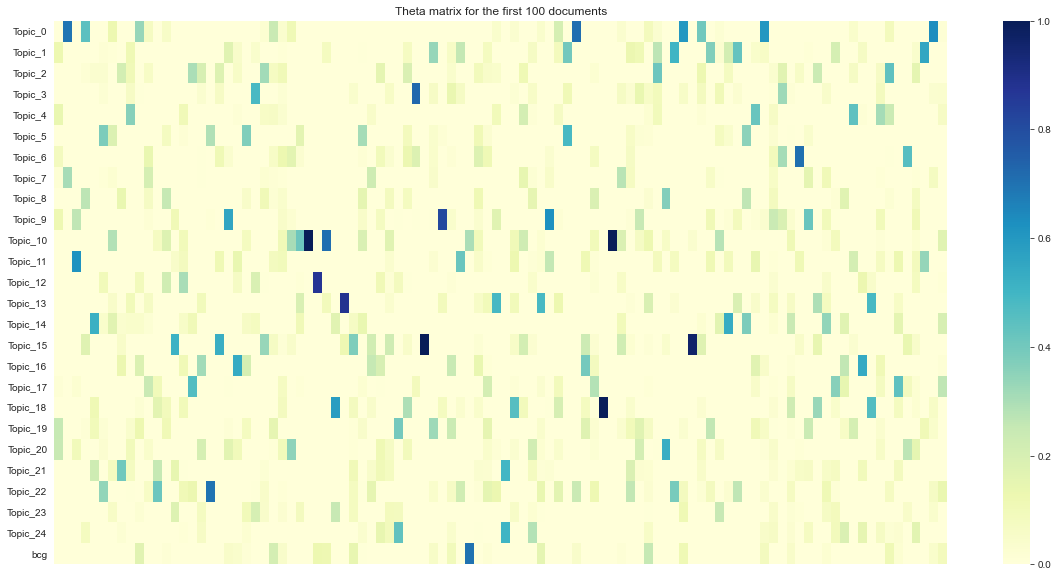

In [29]:
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
sns.heatmap(theta.iloc[:,:100], cmap='YlGnBu', xticklabels=False)
plt.show();

You should see that the background theme has a high likelihood in almost every document, which makes sense. In addition, there is another topic that appears more frequently in documents. Apparently, this topic contains a lot of words on science in general, and every document (video) in our collection is related to science. You can (optionally) name this topic "Science".

Apart from these two topics, background and general scientific, each document is characterized by a small number of other topics.

We estimate $p(t)$ - the share of each topic in the entire collection. Using the formula of total probability, these values should be calculated as $p(t) = \sum_d p(t|d) p(d)$. According to the probabilistic model, $p(d)$ is proportional to the length of the document d. Let's do it easier: we will assume that all documents are equally probable. Then you can estimate $p(t)$ by summing $p(t|d)$ over all documents, and then dividing the resulting vector by its sum.

In [25]:
phi

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
контент,1.693207e-07,1.527618e-07,2.396095e-04,1.075001e-03,2.445137e-07,2.293210e-06,4.455738e-05,3.241420e-06,5.878080e-07,3.972800e-06,3.545468e-06,4.926898e-07,3.965364e-05,1.408117e-04,3.862104e-03
правление,7.625555e-05,2.017741e-07,3.179922e-04,5.668471e-04,5.911453e-05,2.171481e-03,4.471816e-07,6.462421e-06,6.645534e-04,5.976186e-05,2.882636e-04,1.711356e-06,4.709246e-05,1.744570e-03,3.121745e-07
пункт,2.177900e-06,1.288684e-03,3.520960e-04,1.074281e-03,1.403062e-04,8.158378e-05,3.190183e-05,9.570362e-04,1.031847e-03,2.133409e-04,7.250181e-07,2.112871e-04,2.344039e-03,1.004271e-04,8.822651e-06
продлять,1.615542e-04,1.066563e-05,4.342519e-04,5.244968e-05,2.392186e-03,1.000518e-04,5.907122e-05,2.178193e-06,2.240662e-06,3.065826e-04,2.797823e-04,4.665349e-04,8.939544e-04,8.315282e-04,2.981181e-05
валютный,8.690461e-03,1.165877e-06,3.854364e-06,4.684125e-07,1.104422e-03,2.725088e-07,1.512491e-06,8.318336e-04,6.534669e-07,1.990101e-07,6.125876e-06,1.549502e-05,3.698011e-07,3.330141e-07,2.132753e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
рамка,1.094087e-03,6.398451e-04,1.510083e-03,4.292554e-03,2.829669e-03,1.462454e-04,1.136967e-04,2.932227e-04,1.690514e-03,3.941046e-03,4.245350e-03,1.263850e-03,2.792156e-05,8.498616e-07,5.853462e-04
политический,1.607598e-05,1.233738e-03,9.542849e-07,1.142571e-04,3.787868e-04,2.325212e-03,4.344680e-04,6.404400e-04,6.602987e-07,1.146007e-05,2.312927e-04,4.469622e-03,8.270625e-06,3.277352e-05,7.021351e-05
оборудование,1.837054e-06,5.648330e-07,8.401975e-04,3.976018e-05,1.546716e-05,1.087937e-03,3.796006e-03,2.583577e-07,1.077976e-05,9.161266e-04,1.378755e-04,1.181356e-05,5.803739e-05,2.744150e-04,3.507177e-04
поэтому,2.795682e-03,1.335633e-03,4.763518e-03,4.613169e-05,2.904708e-03,4.441927e-05,2.426475e-04,7.796370e-04,1.625547e-04,4.366442e-03,8.105678e-04,6.793300e-04,6.791011e-05,3.453926e-04,3.280731e-05


In [26]:
theta

,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,...,997,998,999,1000,1001,1002,1003,1004,1005,1006
topic_0,0.000913,0.707820,0.000681,0.481919,0.001175,0.000374,0.110531,0.005453,0.000625,0.360487,...,0.000282,0.000770,0.442107,0.435646,0.000362,0.000304,0.001328,0.040762,0.000277,0.000215
topic_1,0.071582,0.001531,0.000853,0.000973,0.000499,0.375967,0.003446,0.000354,0.227172,0.071107,...,0.034701,0.228827,0.002459,0.000291,0.001955,0.167940,0.000672,0.005280,0.248721,0.000215
topic_2,0.000683,0.002194,0.002046,0.214483,0.043365,0.035120,0.000135,0.342716,0.296220,0.040712,...,0.000725,0.038802,0.001132,0.000232,0.006609,0.000416,0.000441,0.000476,0.001174,0.004844
topic_3,0.000843,0.002553,0.000943,0.001505,0.002041,0.077462,0.000237,0.002047,0.022750,0.021877,...,0.022623,0.000362,0.003329,0.178086,0.000326,0.466049,0.000967,0.000773,0.002918,0.270515
topic_4,0.193677,0.001898,0.049096,0.000728,0.001026,0.000527,0.000132,0.231516,0.237084,0.162751,...,0.000412,0.004392,0.001399,0.000398,0.000272,0.002699,0.054998,0.000420,0.337152,0.004965
topic_5,0.081031,0.001612,0.000572,0.000519,0.055473,0.243328,0.225367,0.001044,0.000589,0.052457,...,0.000538,0.154409,0.001090,0.000782,0.000302,0.000678,0.002363,0.000408,0.000799,0.000613
topic_6,0.282476,0.002074,0.163917,0.000725,0.110494,0.000654,0.000228,0.001602,0.018485,0.003018,...,0.028140,0.002930,0.087188,0.008803,0.022541,0.000361,0.000636,0.040374,0.117587,0.304635
topic_7,0.065804,0.263348,0.002105,0.150330,0.000688,0.000777,0.000226,0.009668,0.002629,0.000243,...,0.035054,0.075933,0.166753,0.029351,0.022320,0.000454,0.000765,0.001323,0.000460,0.350282
topic_8,0.000800,0.001519,0.000707,0.110997,0.000513,0.000416,0.003062,0.219376,0.000456,0.000250,...,0.134652,0.055734,0.178897,0.000696,0.160395,0.001163,0.000726,0.109513,0.006306,0.000386
topic_9,0.284982,0.001590,0.293533,0.000724,0.001143,0.000524,0.041224,0.002181,0.000450,0.000356,...,0.054014,0.308987,0.002996,0.000395,0.233093,0.000842,0.000446,0.675656,0.002215,0.028667
